# Fake Job Postings

Link to the source of data: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction <br>
Sorry for my English please /\

## Data

Features list (`Variable`: Definition):

- `job_id`: Unique Job ID<br>
- `title`: The title of the job ad entry<br>
- `location`: Geographical location of the job ad<br>
- `department`: Corporate department (e.g. sales)<br>
- `salary_range`: Indicative salary range (e.g. $50,000-60,000)<br>
- `company_profile`: A brief company description<br>
- `description`: The details description of the job ad<br>
- `requirements`: Enlisted requirements for the job opening<br>
- `benefits`: Enlisted offered benefits by the employer<br>
- `telecommuting`: True for telecommuting positions<br>
- `has_company_logo`: True if company logo is present<br>
- `has_questions`: True if screening questions are present<br>
- `employment_type`: Full-type, Part-time, Contract, etc<br>
- `required_experience`: Executive, Entry level, Intern, etc<br>
- `required_education`: Doctorate, Master’s Degree, Bachelor, etc<br>
- `industry`: Automotive, IT, Health care, Real estate, etc<br>
- `function`: Consulting, Engineering, Research, Sales etc<br>
- `fraudulent`: target - Classification attribute<br>

__fake_job_postings.csv__ - the dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
from tqdm import tqdm
from collections import Counter
from itertools import tee

from IPython.display import display

import numpy as np
import scipy as sp
from scipy import stats
from scipy.sparse import hstack as sparse_hstack
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from statsmodels.stats.weightstats import zconfint
import pandas as pd

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

import eli5

Using TensorFlow backend.


In [2]:
import mystatutils as stats

## First look

The dataset:

In [196]:
data = pd.read_csv('fake_job_postings.csv')
data.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

There are many NA-values in the table and there are features that have to be preprocessed for further usage. Let's save names of each feature-type and work on complex ones.

In [198]:
bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
cat_features = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']

And drop `job_id`, it's useless.

In [199]:
data.drop('job_id', axis=1, inplace=True)

## Feature preparation

### Text features

Features that describe textual components of job post:

In [200]:
data[text_features].head()

,title,company_profile,description,requirements,benefits
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


Adding indicators of specified values (there is no NA-values in `title`):

In [201]:
for feature_name in text_features[1:]:
    unspec_feature_name = f'{feature_name}_specified'
    data[unspec_feature_name] = (~data[feature_name].isna()).astype('int')
    bin_features += [unspec_feature_name]

In [202]:
data.head()[text_features + bin_features[-4:]]

,title,company_profile,description,requirements,benefits,company_profile_specified,description_specified,requirements_specified,benefits_specified
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,1,1,1,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,1,1,1,1
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,1,1,1,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,1,1,1,1
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,1,1,1,1


Filling NA-values with an empty string:

In [203]:
for feature_name in text_features[1:]:
    data[feature_name].fillna('', inplace=True)

Now we have to clean our texts from punctuation marks and stop-words, and apply stemming:

In [204]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [205]:
nltk_supported_languages = ['hungarian', 'swedish', 'kazakh', 'norwegian',
                            'finnish', 'arabic', 'indonesian', 'portuguese',
                            'turkish', 'azerbaijani', 'slovene', 'spanish',
                            'danish', 'nepali', 'romanian', 'greek', 'dutch',
                            'tajik', 'german', 'english', 'russian',
                            'french', 'italian']

In [206]:
# stop words list
stop_words = set(stopwords.words(nltk_supported_languages))

In [207]:
# stemmer
porter = PorterStemmer()

In [208]:
def preprocess_texts(texts):
    '''Returns a list of clean and word-stemmed strings.'''
    preprocessed_texts = []
    for text in tqdm(texts):
        # punctuation marks cleaning
        text = ''.join([sym.lower() for sym in text if sym.isalpha() or sym == ' '])
        
        # tokenization
        tokenized_text = word_tokenize(text)
        
        # stop words cleaning
        tokenized_text_wout_sw = [word for word in tokenized_text if word not in stop_words]
        
        # stemming
        tokenized_text_wout_sw_stem = [porter.stem(word) for word in tokenized_text_wout_sw]
        
        # saving result
        preprocessed_texts += [' '.join(tokenized_text_wout_sw_stem)]
    
    return preprocessed_texts

In [209]:
%%time
for feature_name in text_features:
    data[feature_name] = preprocess_texts(data[feature_name])

data[text_features].head()

100%|██████████| 17880/17880 [00:17<00:00, 1051.71it/s]

CPU times: user 3min 21s, sys: 1.13 s, total: 3min 22s
Wall time: 3min 23s


,title,company_profile,description,requirements,benefits
0,market intern,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,
1,custom servic cloud video product,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...
2,commiss machineri assist cma,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,
3,account execut washington dc,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...
4,bill review manag,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer


Done! Now move on to complex features.

### Complex features

#### `location`

The main structure of `location`'s values is `Country, State, City`:

In [210]:
location = data['location'].copy()
location.head(15)

0          US, NY, New York
1            NZ, , Auckland
2             US, IA, Wever
3        US, DC, Washington
4        US, FL, Fort Worth
5                  US, MD, 
6            DE, BE, Berlin
7     US, CA, San Francisco
8         US, FL, Pensacola
9           US, AZ, Phoenix
10      US, NJ, Jersey City
11          GB, LND, London
12         US, CT, Stamford
13          US, FL, Orlando
14          AU, NSW, Sydney
Name: location, dtype: object

Let's divide and extract these elements. We will use them as a categorical features in the future.

In [211]:
location_splitted = list(location.str.split(', ').values)
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', ''],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

Filling in missing values (we will use `'Unspecified'` word to replace NA-values for all categorical features):

In [212]:
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'Unpecified'

In [213]:
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', 'Unpecified', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', 'Unpecified'],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

But there are some troubles:

In [214]:
any([len(loc) > 3 for loc in location_splitted])

True

In [215]:
any([len(loc) < 3 for loc in location_splitted])

True

Not all values of `location` were described in 3 elements. Let's look at unusual values:

In [216]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        print(loc_ind, loc)

16 ['IL', 'Unpecified', 'Tel Aviv', 'Israel']
69 ['US', 'CA', 'Menlo Park', 'CA']
98 ['US', 'Unpecified', 'Stocton', 'CA']
215 ['US', 'CA', 'Bakersfield', 'CA / Mt. Poso']
219 ['SA', '01', 'Riyadh', 'Olaya']
314 ['EG', 'C', 'Cairo', 'Nasr City']
343 ['GR', 'I', 'Neo Iraklio', 'Athens']
440 ['GB', 'UKM', 'Stockholm', 'Sweden']
695 ['GB', 'Unpecified', 'Angel', 'London']
980 ['US', 'CO', 'Boulder', 'CO']
1725 ['US', 'TX', 'Austin', 'San Antonio', 'Houston']
2015 ['EG', 'C', 'Cairo', 'Nasr City']
2094 ['US', 'NJ', 'Hillside', 'NJ']
2320 ['GR', 'I', 'Vrilissia ', 'Greece']
2362 ['GR', 'E', 'Larisa', 'Volos']
2694 ['GR', 'I', 'Chalandri', 'Athens']
2745 ['US', 'NJ', 'Whitehouse station', 'Unpecified']
2947 ['US', 'DC', 'Washington', 'DC']
3062 ['US', 'CA', 'Salinas', 'CA']
3451 ['US', 'CA', 'Fresno', 'CA']
3630 ['SA', '01', 'Riyadh', 'Olaya']
4073 ['US', 'FL', 'Okeechobee', 'FL']
4117 ['GR', 'I', 'Athens', 'Rouf']
4221 ['CA', 'Unpecified', 'Rio Rancho', 'NM']
4333 ['GR', 'I', 'Kifisia', 'At

In [217]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) < 3:
        print(loc_ind, loc)

42 ['US']
173 ['US']
230 ['US']
368 ['US']
392 ['US']
502 ['US']
540 ['US']
866 ['AU']
895 ['US']
962 ['GR']
994 ['US']
1033 ['CA']
1360 ['HK']
1661 ['DE']
1697 ['GB']
1714 ['US']
1784 ['US']
1803 ['US']
1981 ['IN']
2180 ['US']
2247 ['US']
2269 ['US']
2288 ['US']
2330 ['US']
2416 ['US']
2562 ['US']
2653 ['US']
2760 ['US']
2930 ['US']
3179 ['GB']
3510 ['US']
3690 ['US']
3784 ['US']
3956 ['AU']
4130 ['US']
4146 ['US']
4192 ['GR']
4193 ['US']
4211 ['GB']
4399 ['GB']
4569 ['US']
4726 ['US']
5276 ['US']
5476 ['US']
5813 ['BE']
5948 ['CN']
7159 ['TH']
7411 ['US']
7421 ['US']
7450 ['QA']
7462 ['US']
7495 ['US']
7518 ['US']
7700 ['US']
7838 ['US']
7858 ['US']
7911 ['US']
7920 ['US']
7996 ['GR']
8056 ['NZ']
8776 ['GB']
8841 ['QA']
9952 ['GB']
10101 ['US']
10407 ['GB']
10452 ['US']
10538 ['US']
10550 ['US']
10895 ['GB']
11130 ['US']
11643 ['US']
11664 ['US']
11935 ['AU']
12042 ['IN']
12069 ['IL']
12116 ['US']
13042 ['US']
13206 ['DE']
13259 ['US']
13462 ['US']
13780 ['GB']
13994 ['US']
14043 ['G

To resolve these problems a strange move have to be undertaken due to this oddity:

In [218]:
location_splitted[0] is list

False

In [219]:
type(location_splitted[0])

list

In [220]:
location_splitted = list(map(lambda loc: list(loc), location_splitted))

Most of the problems arose due to the refinement of the position at the third element using a comma. Let's resolve it simply (and supplement values in which only the country is specified):

In [221]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['Unpecified'] * 2

Alright:

In [222]:
any([len(loc) != 3 for loc in location_splitted])

False

Now let's add new features to the dataset table and remove the old one from it:

In [223]:
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
data_location.head(15)

,country,state,city
0,US,NY,New York
1,NZ,Unpecified,Auckland
2,US,IA,Wever
3,US,DC,Washington
4,US,FL,Fort Worth
5,US,MD,Unpecified
6,DE,BE,Berlin
7,US,CA,San Francisco
8,US,FL,Pensacola
9,US,AZ,Phoenix


In [224]:
# complementing the list of categorical features
cat_features += ['country', 'state', 'city']

In [225]:
data = pd.concat([data, data_location], axis=1)
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,industry,function,fraudulent,company_profile_specified,description_specified,requirements_specified,benefits_specified,country,state,city
0,market intern,"US, NY, New York",Marketing,NaN,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,,0,1,...,NaN,Marketing,0,1,1,1,0,US,NY,New York
1,custom servic cloud video product,"NZ, , Auckland",Success,NaN,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...,0,1,...,Marketing and Advertising,Customer Service,0,1,1,1,1,NZ,Unpecified,Auckland
2,commiss machineri assist cma,"US, IA, Wever",NaN,NaN,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,,0,1,...,NaN,NaN,0,1,1,1,0,US,IA,Wever
3,account execut washington dc,"US, DC, Washington",Sales,NaN,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...,0,1,...,Computer Software,Sales,0,1,1,1,1,US,DC,Washington
4,bill review manag,"US, FL, Fort Worth",NaN,NaN,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0,1,...,Hospital & Health Care,Health Care Provider,0,1,1,1,1,US,FL,Fort Worth


In [226]:
data.drop('location', axis=1, inplace=True)

#### `salary_range`

Now we need to do something with the `salary_range` column because we can't work with it as with a categorical feature:

In [227]:
salary_range = data.salary_range.copy()
salary_range.head(15)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6       20000-28000
7               NaN
8               NaN
9               NaN
10    100000-120000
11              NaN
12              NaN
13              NaN
14              NaN
Name: salary_range, dtype: object

Filling in the missing values with a `0-0` value (in the future we will create an indicator for the unspecified data):

In [228]:
salary_range.fillna('0-0', inplace=True)

And splitting them:

In [229]:
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[:5]

[['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']]

Checking for unusual values:

In [230]:
for range_ind, s_range in enumerate(salary_range_sep):
    if len(s_range) < 2 or len(s_range) > 2:
        print(range_ind, s_range)

5538 ['40000']


And fixing it:

In [231]:
salary_range_sep[5538] = ['40000', '40000']

Not all gained values are numerical:

In [232]:
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        print(range_ind, (min_value, max_value))
        error_range_inds += [range_ind]

159 ('9', 'Dec')
1884 ('3', 'Apr')
1981 ('4', 'Apr')
2313 ('Oct', '15')
4299 ('8', 'Sep')
9124 ('4', 'Jun')
9902 ('10', 'Oct')
9911 ('Oct', '20')
10316 ('Jun', '18')
10785 ('10', 'Oct')
10788 ('11', 'Nov')
10860 ('10', 'Nov')
10883 ('10', 'Oct')
10889 ('10', 'Nov')
10896 ('10', 'Oct')
10905 ('10', 'Nov')
11361 ('11', 'Dec')
11495 ('2', 'Apr')
11606 ('10', 'Nov')
12421 ('10', 'Oct')
13449 ('11', 'Nov')
13482 ('2', 'Jun')
14196 ('Oct', '20')
15483 ('10', 'Oct')
17233 ('10', 'Nov')
17656 ('Dec', '25')


Somebody specified some kind of dates instead of salary range, let's replace these values with a `['0', '0']`:

In [233]:
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']

Saving results into a `pandas.DataFrame` object:

In [234]:
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])
data_salary_range.head(15)

,min_salary,max_salary
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,20000,28000
7,0,0
8,0,0
9,0,0


Adding a column for marking specified salary ranges:

In [235]:
data_salary_range['salary_specified'] = ((data_salary_range.min_salary != 0) | 
                                         (data_salary_range.max_salary != 0)).astype('int64')
data_salary_range.head(15)

,min_salary,max_salary,salary_specified
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,20000,28000,1
7,0,0,0
8,0,0,0
9,0,0,0


In [236]:
# creating the list of numerical features names and complementing the list of binary ones
num_features = ['min_salary', 'max_salary']
bin_features += ['salary_specified']

And saving results into the original table:

In [237]:
data = pd.concat([data, data_salary_range], axis=1)
data.head()

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,company_profile_specified,description_specified,requirements_specified,benefits_specified,country,state,city,min_salary,max_salary,salary_specified
0,market intern,Marketing,NaN,food weve creat groundbreak awardwin cook site...,food fastgrow jame beard awardwin onlin food c...,experi content manag system major plu blog cou...,,0,1,0,...,1,1,1,0,US,NY,New York,0,0,0
1,custom servic cloud video product,Success,NaN,second world cloud video product servic second...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client secon...,get usthrough part second team gainexperi work...,0,1,0,...,1,1,1,1,NZ,Unpecified,Auckland,0,0,0
2,commiss machineri assist cma,NaN,NaN,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,,0,1,0,...,1,1,1,0,US,IA,Wever,0,0,0
3,account execut washington dc,Sales,NaN,passion improv qualiti life geographi heart ev...,compani esri environment system research insti...,educationbachelor master gi busi administr rel...,cultur anyth corporatew collabor creativ envir...,0,1,0,...,1,1,1,1,US,DC,Washington,0,0,0
4,bill review manag,NaN,NaN,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0,1,1,...,1,1,1,1,US,FL,Fort Worth,0,0,0


In [238]:
data.drop('salary_range', axis=1, inplace=True)

### Other features

We still have NA-values in other columns:

In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      17880 non-null  object
 1   department                 6333 non-null   object
 2   company_profile            17880 non-null  object
 3   description                17880 non-null  object
 4   requirements               17880 non-null  object
 5   benefits                   17880 non-null  object
 6   telecommuting              17880 non-null  int64 
 7   has_company_logo           17880 non-null  int64 
 8   has_questions              17880 non-null  int64 
 9   employment_type            14409 non-null  object
 10  required_experience        10830 non-null  object
 11  required_education         9775 non-null   object
 12  industry                   12977 non-null  object
 13  function                   11425 non-null  object
 14  fraudu

But the rest features are categorical so we will fill the missing values using `'Unspecified'` value:

In [240]:
data.fillna('Unspecified', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      17880 non-null  object
 1   department                 17880 non-null  object
 2   company_profile            17880 non-null  object
 3   description                17880 non-null  object
 4   requirements               17880 non-null  object
 5   benefits                   17880 non-null  object
 6   telecommuting              17880 non-null  int64 
 7   has_company_logo           17880 non-null  int64 
 8   has_questions              17880 non-null  int64 
 9   employment_type            17880 non-null  object
 10  required_experience        17880 non-null  object
 11  required_education         17880 non-null  object
 12  industry                   17880 non-null  object
 13  function                   17880 non-null  object
 14  fraudu

## Analysis

Let's look at the distribution of the target feature:

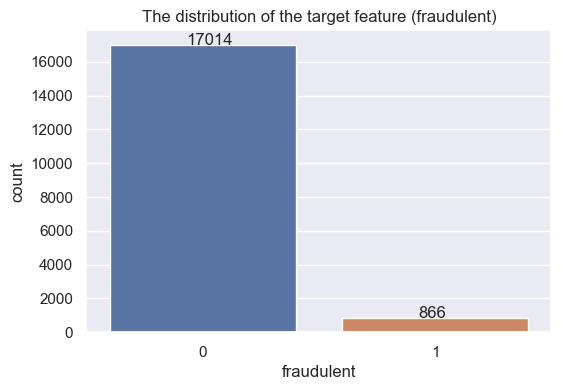

In [48]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))

plt.show()

Classes are not balanced, so we have to use oversampling/undersampling and calculate \[not-only-accuracy\] metrics (ROC AUC, etc.) to estimate our models in the future.

Distributions of binary features:

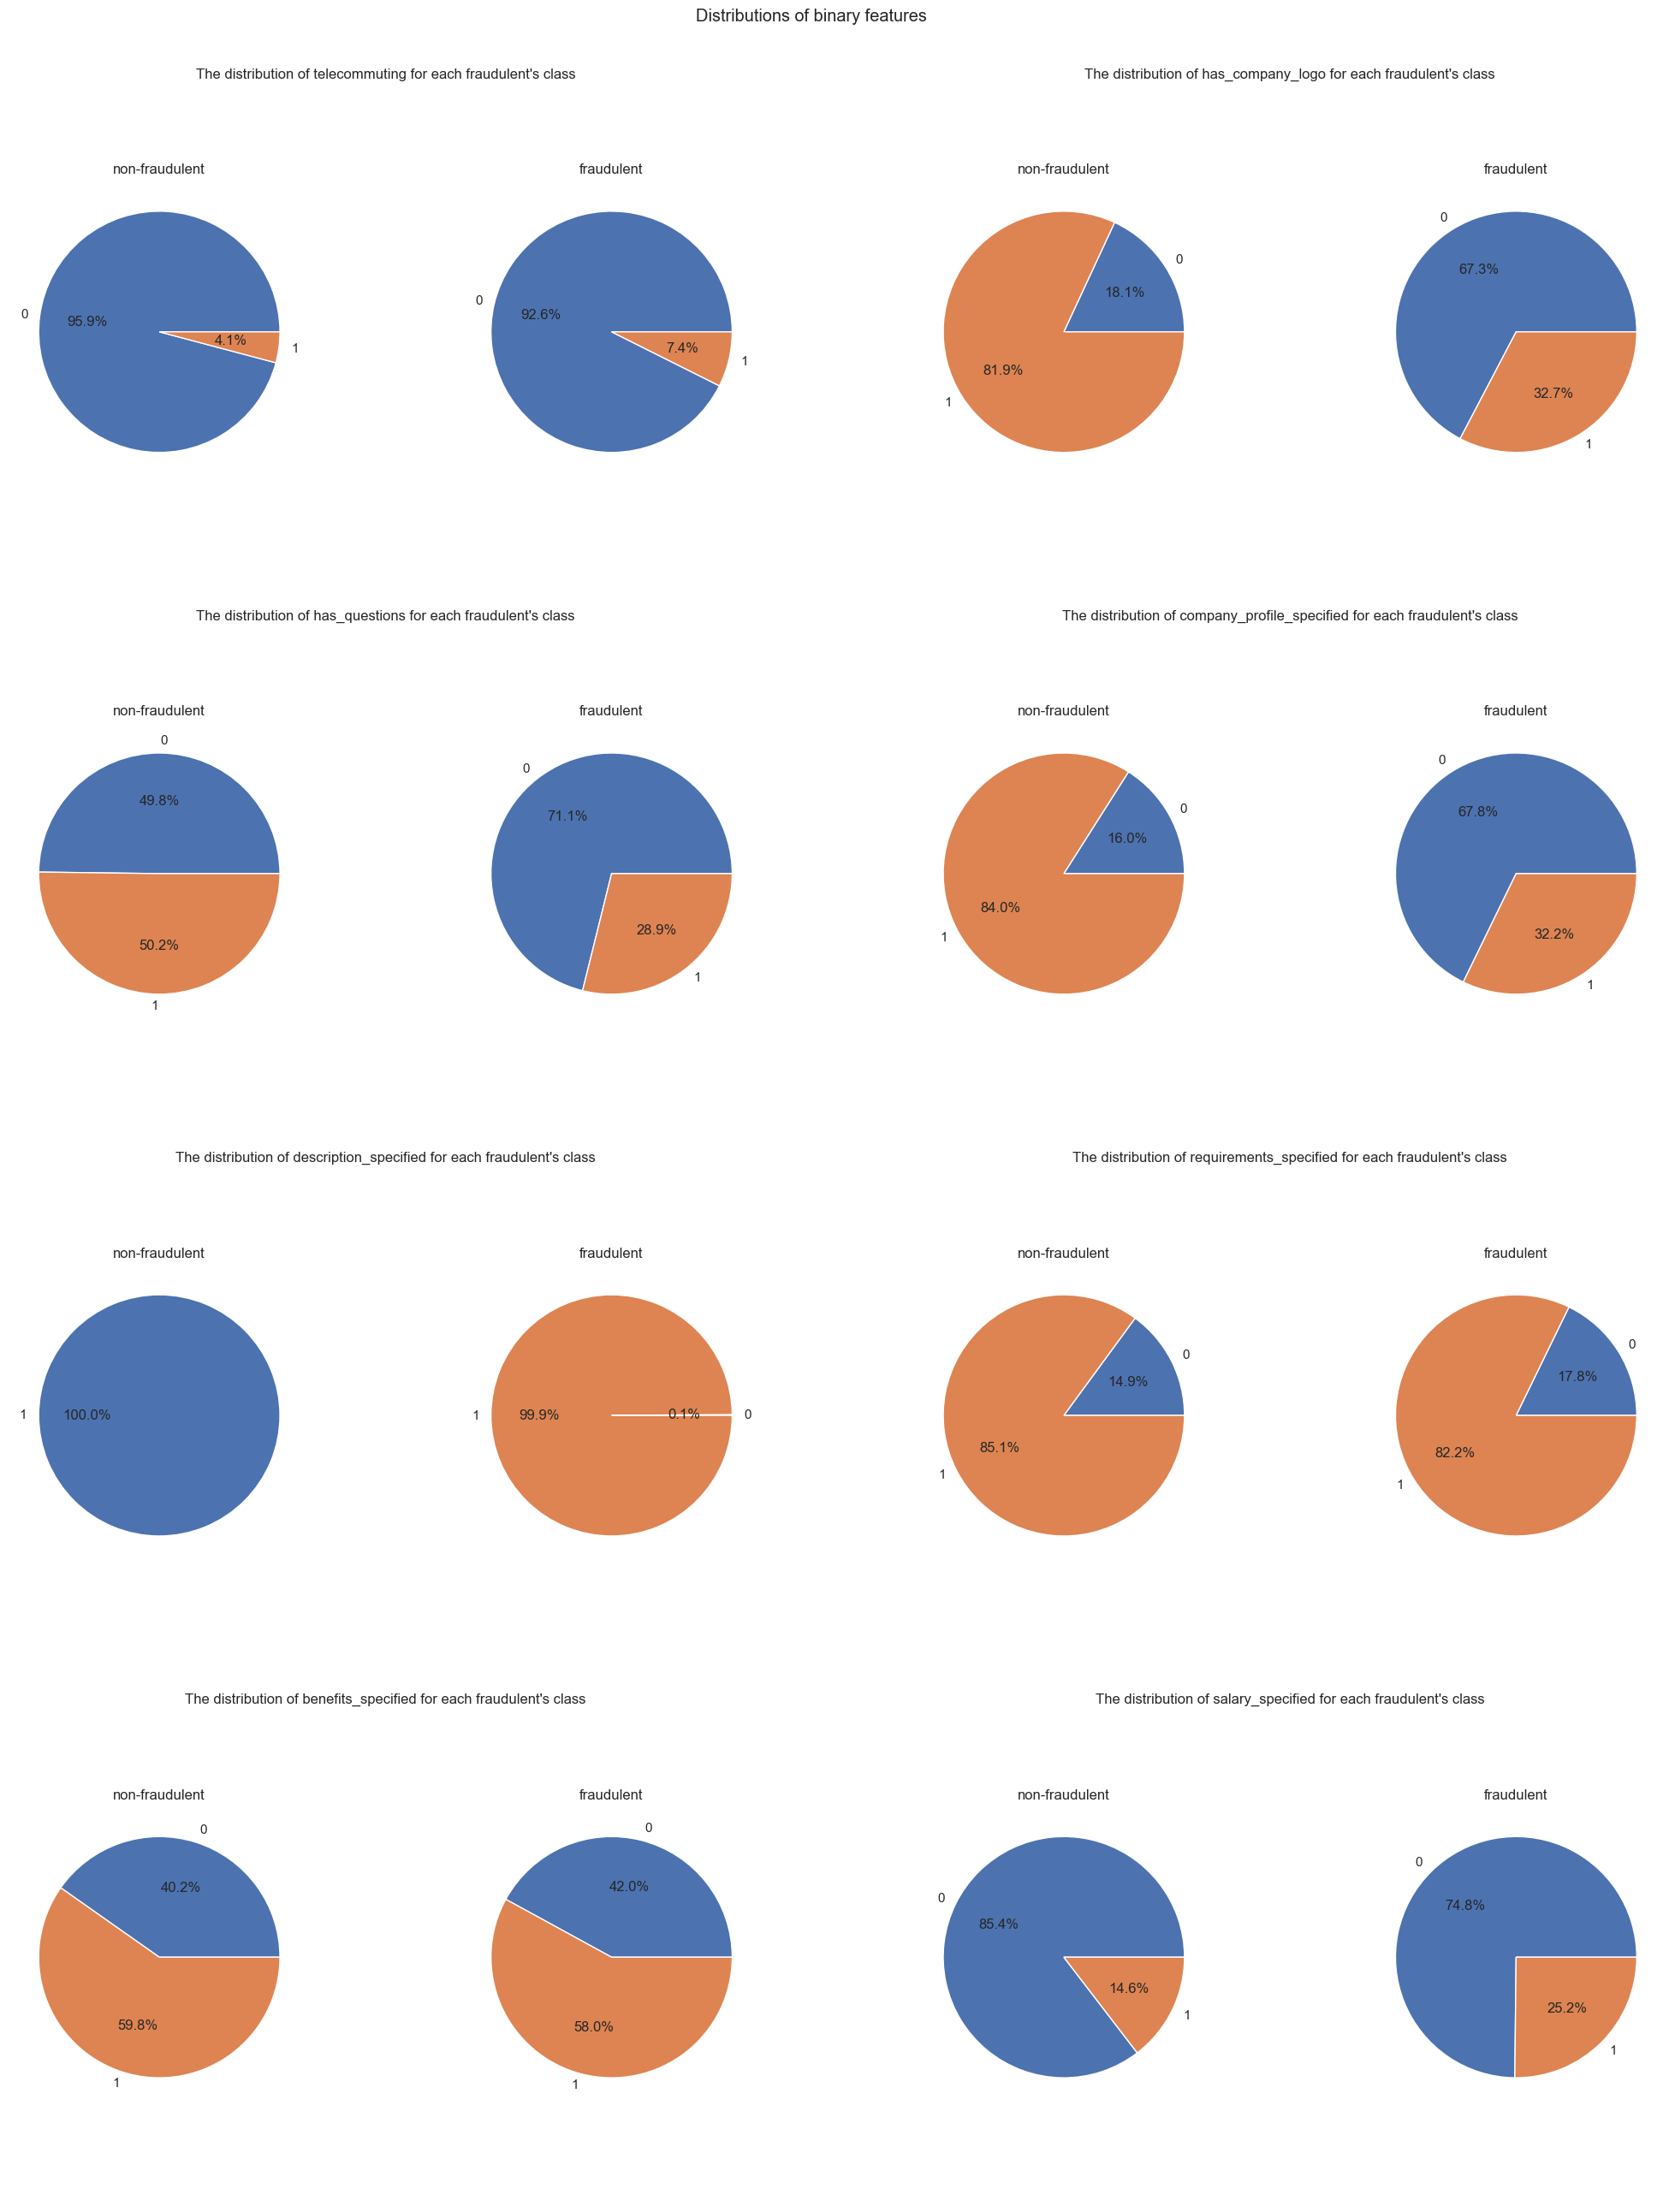

In [49]:
fig = plt.figure(figsize=(25, 30))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.1)

for feature_ind, feature_name in enumerate(bin_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                             wspace=0.5, hspace=0.7)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of {feature_name} for each fraudulent\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for fr_class in [0, 1]:
        ax = plt.Subplot(fig, inner[fr_class])
        feature_f_vc = data[data.fraudulent == fr_class][feature_name].value_counts().sort_index()
        ax.pie(feature_f_vc.values, labels=feature_f_vc.index, autopct='%1.1f%%')
        # ax.set_title(f'fraudulent = {fr_class}')
        ax.set_title(f'{"non-" if not fr_class else ""}fraudulent')
        fig.add_subplot(ax)

fig.suptitle('Distributions of binary features')
fig.subplots_adjust(top=0.95)
fig.show()

Look's like those who post fraudulent posts more often don't have company logo/company profile and more often indicate in their posts that there will be no screening questions at the survey. Also fraudulent post writers less often specify salary.

Let's check how some of binary features may be related:

In [104]:
def show_feature1_x_feature2_info(feature_name1, feature_name2, figsize=(12, 4), is_binxcat=False):
    '''Shows info about a combination of two binary/categorical features.'''
    cont_table = pd.crosstab(data[feature_name1], data[feature_name2]).fillna(0)
    prop_table = pd.pivot_table(data, index=feature_name1, columns=feature_name2, 
                                values='fraudulent', aggfunc=np.mean).fillna(0)
    
    corr, p = stats.cramers_v(cont_table.values)
    
    if is_binxcat:
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(cont_table, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'Contingency table:')
    if is_binxcat:
        axes[0].set_xlabel('')
    
    sns.heatmap(prop_table, annot=True, ax=axes[1])
    axes[1].set_title(f'Proportion of fraudulent posts:')
    
    fig_title = f'{feature_name1} x {feature_name2} (Correlation: {round(corr, 4)}, p-value: {round(p, 4)}))'
    if is_binxcat:
        fig.suptitle(fig_title, y=1.05, x=0.45)
    else:
        fig.suptitle(fig_title, y=1.05)
    
    fig.show()

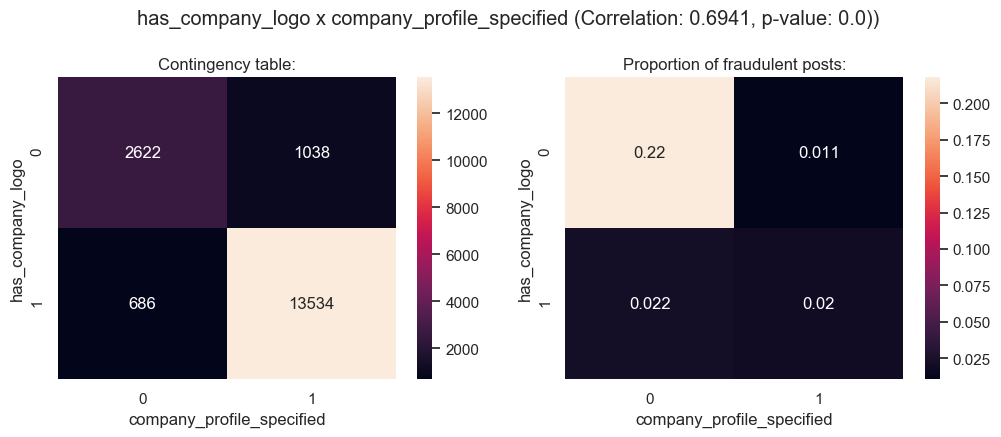

In [105]:
show_feature1_x_feature2_info('has_company_logo', 'company_profile_specified')

The biggest probability of being fraudulent have posts without company's profile and logo, the smallest - posts that have them.

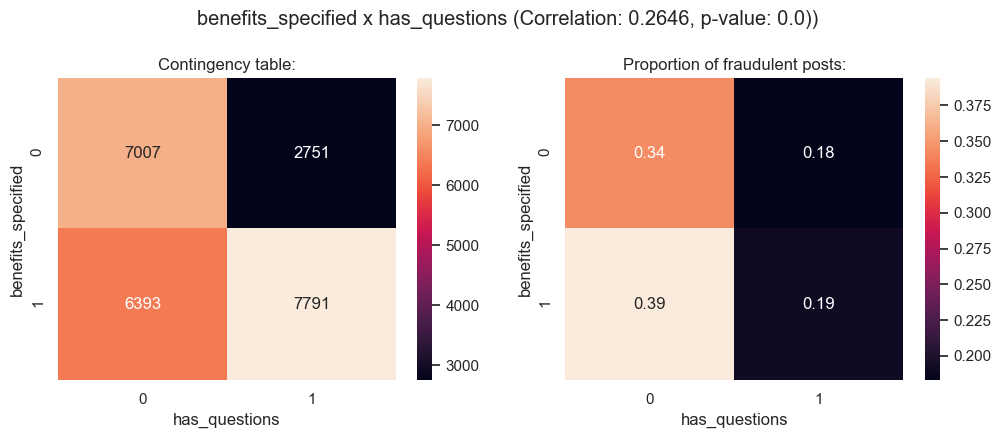

In [188]:
show_feature1_x_feature2_info('benefits_specified', 'has_questions')

The biggest probability of being fraudulent have posts with specified benefits and without announcement of any questions during interview.

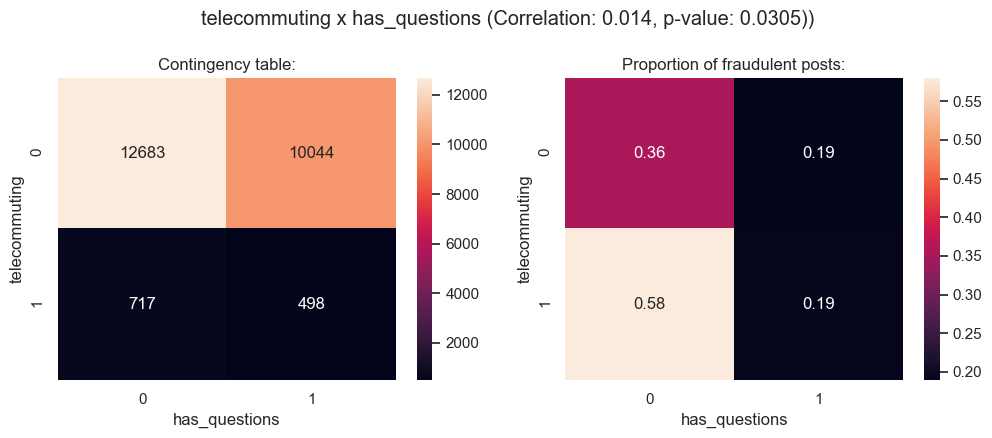

In [189]:
show_feature1_x_feature2_info('telecommuting', 'has_questions')

The biggest probability of being fraudulent have posts that offer remote work and promise an interview without questions.

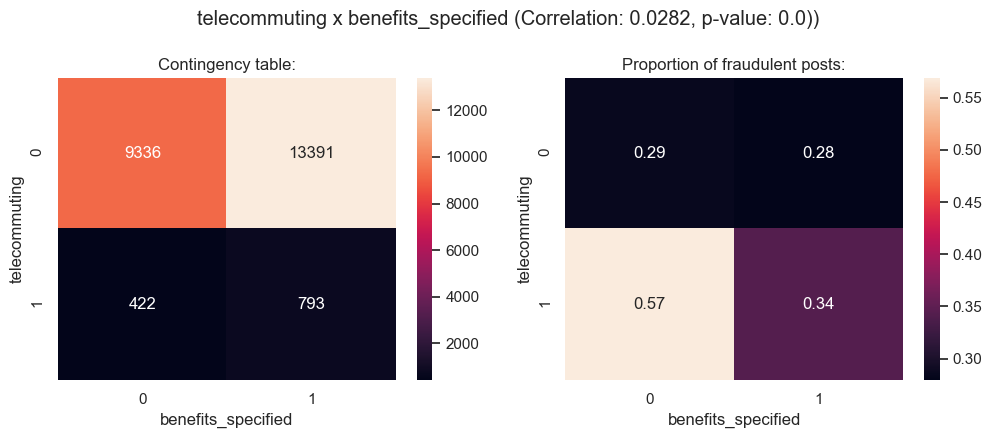

In [190]:
show_feature1_x_feature2_info('telecommuting', 'benefits_specified')

The biggest probability of being fraudulent have posts that offer remote work and don't specify any benefits.

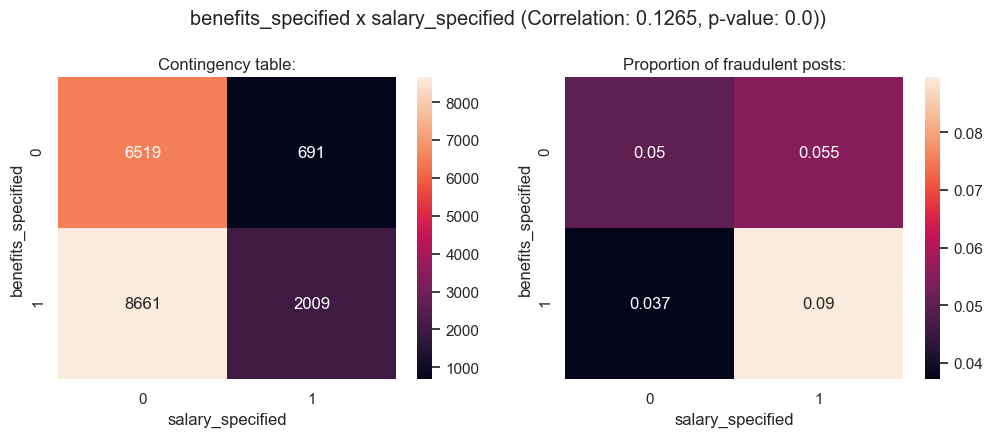

In [107]:
show_feature1_x_feature2_info('benefits_specified', 'salary_specified')

The biggest probability of being fraudulent have posts that includes specified benefits and specified salaries.

Let's check whether proportions of `has_questions` and `salary_specified` for non-fraudulent and fraudulent posts are significantly different:

In [118]:
round_confint = lambda confint: list(map(lambda lim: round(lim, 4), confint))

In [241]:
def print_stats_for_proportions(feature_name):
    '''Calculates statistics for fraudulent and non-fraudulent proportions of a feature.'''
    feature_0f = data[data.fraudulent == 0][feature_name]
    feature_1f = data[data.fraudulent == 1][feature_name]
    
    prop_0f = round(np.mean(feature_0f), 4)
    prop_1f = round(np.mean(feature_1f), 4)
    prop_0f_confint = round_confint(stats.proportion_confint(feature_0f))
    prop_1f_confint = round_confint(stats.proportion_confint(feature_1f))
    
    bigger_prop, smaller_prop = (feature_0f, feature_1f) if prop_0f > prop_1f else (feature_1f, feature_0f)
    props_diff = round(np.mean(bigger_prop) - np.mean(smaller_prop), 4)
    props_diff_confint = round_confint(stats.proportions_diff_confint_ind(bigger_prop, smaller_prop))
    z_test_p = stats.proportions_ztest_ind(feature_0f, feature_1f)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Proportion of {feature_name} for non-fraudulent posts: {prop_0f}')
    print(f'Proportion of {feature_name} for fraudulent posts:     {prop_1f}')
    print(f'Confidence interval for the proportion of {feature_name} for non-fraudulent posts: {prop_0f_confint}')
    print(f'Confidence interval for the proportion of {feature_name} for fraudulent posts:     {prop_1f_confint}')
    print(f'Difference in these proportions: {props_diff}')
    print(f'Confidence interval for the difference in these proportions: {props_diff_confint}')
    print(f'Z-test result: {z_test_p} (p-value)')

In [242]:
print_stats_for_proportions('has_questions')

Feature: has_questions
Proportion of has_questions for non-fraudulent posts: 0.5021
Proportion of has_questions for fraudulent posts:     0.2887
Confidence interval for the proportion of has_questions for non-fraudulent posts: [0.4945, 0.5096]
Confidence interval for the proportion of has_questions for fraudulent posts:     [0.2595, 0.3197]
Difference in these proportions: 0.2134
Confidence interval for the difference in these proportions: [0.1823, 0.2445]
Z-test result: 0.0 (p-value)


In [243]:
print_stats_for_proportions('salary_specified')

Feature: salary_specified
Proportion of salary_specified for non-fraudulent posts: 0.1459
Proportion of salary_specified for fraudulent posts:     0.2517
Confidence interval for the proportion of salary_specified for non-fraudulent posts: [0.1407, 0.1513]
Confidence interval for the proportion of salary_specified for fraudulent posts:     [0.224, 0.2817]
Difference in these proportions: 0.1059
Confidence interval for the difference in these proportions: [0.0765, 0.1352]
Z-test result: 0.0 (p-value)


---

Differences in proportions of all binary features are statistically significant for target variable prediction (the `telecommuting` is least significant, the `has_company_logo` is most).

Let's look at categorical features:

In [115]:
for feature_name in cat_features:
    print(f'Count of {feature_name}\'s unique values: {data[feature_name].unique().shape[0]}')

Count of department's unique values: 1338
Count of employment_type's unique values: 6
Count of required_experience's unique values: 8
Count of required_education's unique values: 14
Count of industry's unique values: 132
Count of function's unique values: 38
Count of country's unique values: 91
Count of state's unique values: 325
Count of city's unique values: 2388


It will be difficult to make any kind of plot for every categorical feature due to the number of classes in most of them. Let's plot ones that have fewer amount of classes (`plotly` charts fit better for this):

In [166]:
def plot_cat_feature_distribution(feature_name, save_as_image=True):
    '''Makes a plotly chart with categorical feature\'s distribution.'''
    feature_0f = data[data.fraudulent == 0][feature_name].value_counts()
    feature_1f = data[data.fraudulent == 1][feature_name].value_counts()
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                        subplot_titles=['non-fraudulent', 'fraudulent'])
    fig.add_trace(go.Pie(labels=feature_0f.index, 
                         values=feature_0f.values), 
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=feature_1f.index, 
                         values=feature_1f.values), 
                  row=1, col=2)
    
    fig.update_layout(title_text=f'The distribution of {feature_name}')
    fig.show()
    
    if save_as_image:
        fig.write_image(f'images/{feature_name}_distribution.png', width=1200, height=800)

In [167]:
plot_cat_feature_distribution('employment_type')

In [168]:
plot_cat_feature_distribution('required_experience')

In [169]:
plot_cat_feature_distribution('required_education')

---

In [342]:
func_meanfr_pt = pd.pivot_table(data, index='function', values='fraudulent', 
                                aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
func_meanfr_pt.columns = ['Proportion of fraudulent posts']
print('Top-15 function\'s values with the biggest proportions of fraudulent posts:')
display(func_meanfr_pt.head(15))

Top-15 function's values with the biggest proportions of fraudulent posts:


,Proportion of fraudulent posts
function,
Administrative,0.188889
Financial Analyst,0.151515
Accounting/Auditing,0.136792
Distribution,0.125000
Other,0.098462
Finance,0.087209
Engineering,0.083828
Business Development,0.057018
Advertising,0.055556


In [343]:
country_meanfr_pt = pd.pivot_table(data, index='country', values='fraudulent', 
                                   aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
country_meanfr_pt.columns = ['Proportion of fraudulent posts']
print('Top-15 country\'s values with the biggest proportions of fraudulent posts:')
display(country_meanfr_pt.head(15))

Top-15 country's values with the biggest proportions of fraudulent posts:


,Proportion of fraudulent posts
country,
MY,0.571429
BH,0.555556
TW,0.500000
QA,0.285714
AU,0.186916
ID,0.076923
US,0.068506
SA,0.066667
Unpecified,0.054913


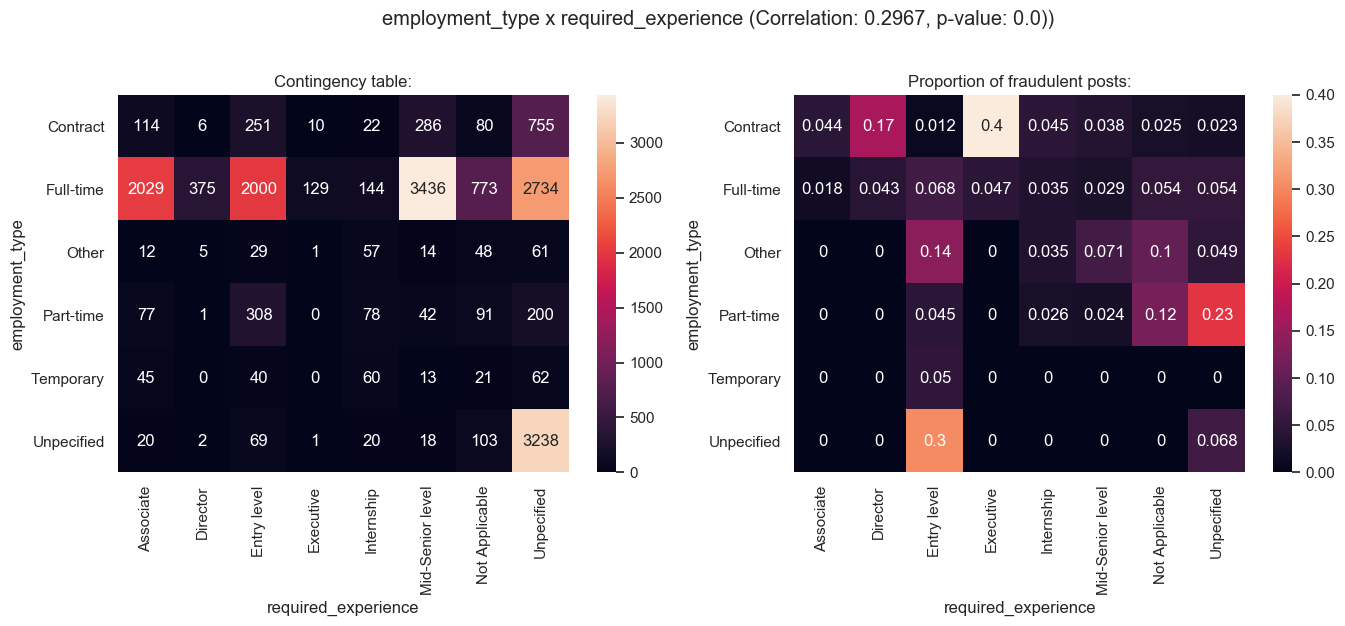

In [108]:
show_feature1_x_feature2_info('employment_type', 'required_experience', (16, 5))

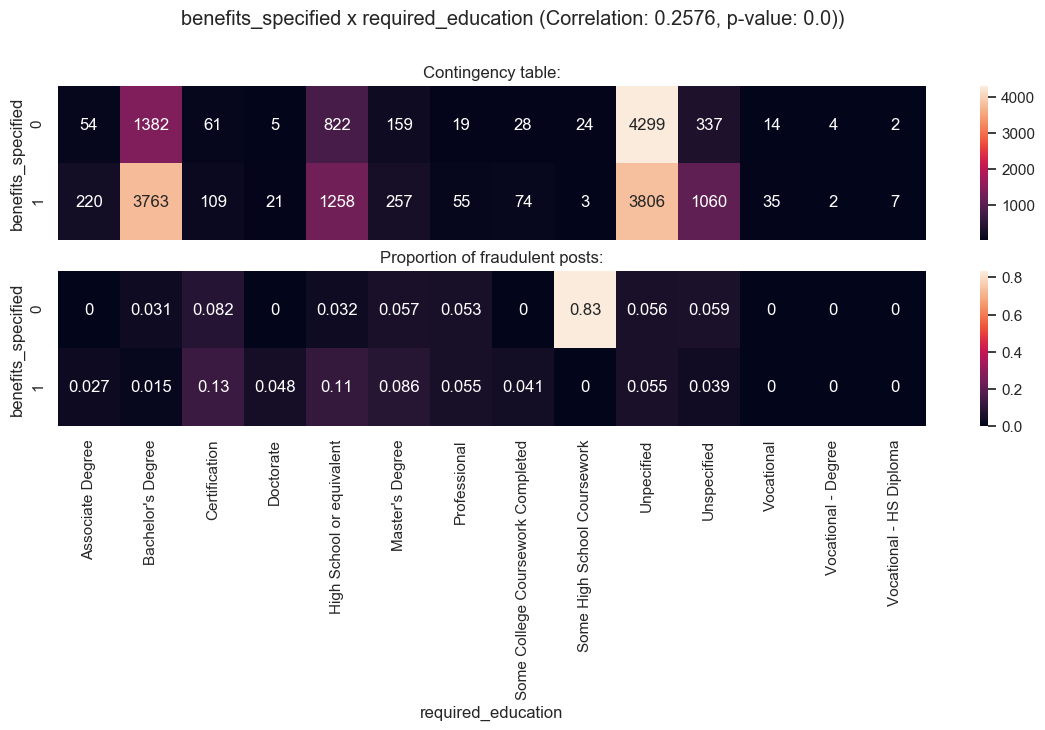

In [109]:
show_feature1_x_feature2_info('benefits_specified', 'required_education', (14, 4.5), True)

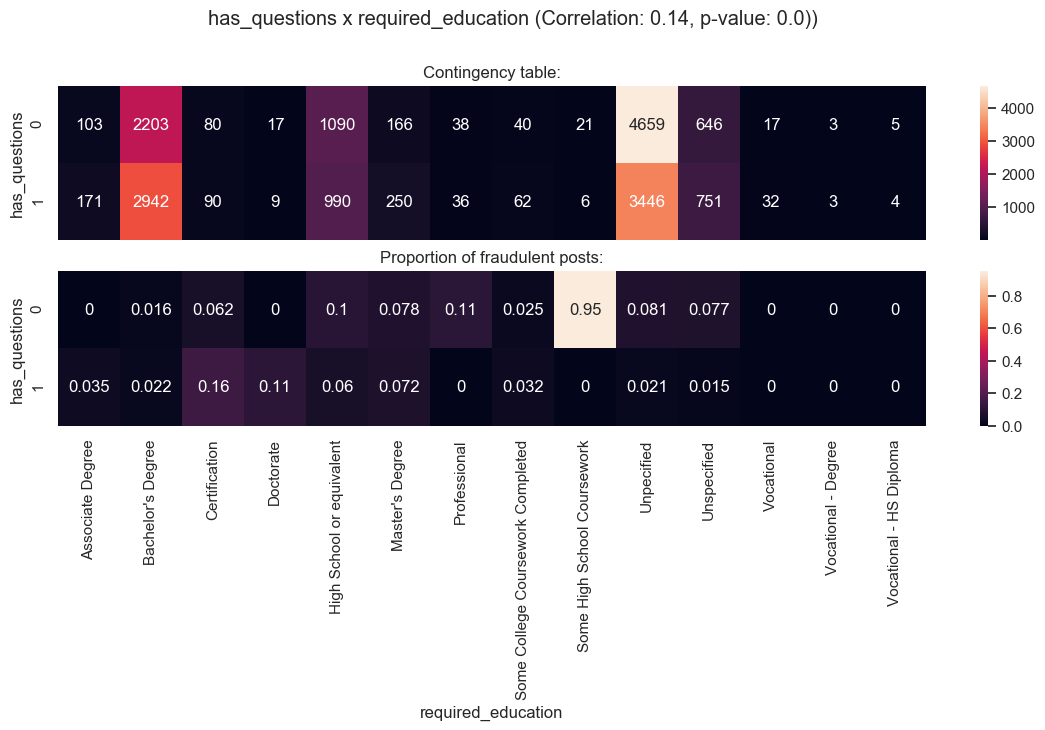

In [110]:
show_feature1_x_feature2_info('has_questions', 'required_education', (14, 4.5), True)

---

Let's check whether proportions of `fraudulent` for each categorical feature's class-value are uniformly distributed using $\chi^2$ test (check if all proportions are equal for every class for each feature):

`stats.chisquare` returns `nan` when a big count of observations is passed... Though differencies of `fraudulent` proportions in `employment_type`, `required_experience`, `required_education` and `function` classes are significant for `fraudulent` prediction.

---

Now let's look at numerical features (salary info):

In [134]:
num_features = ['min_salary', 'max_salary']

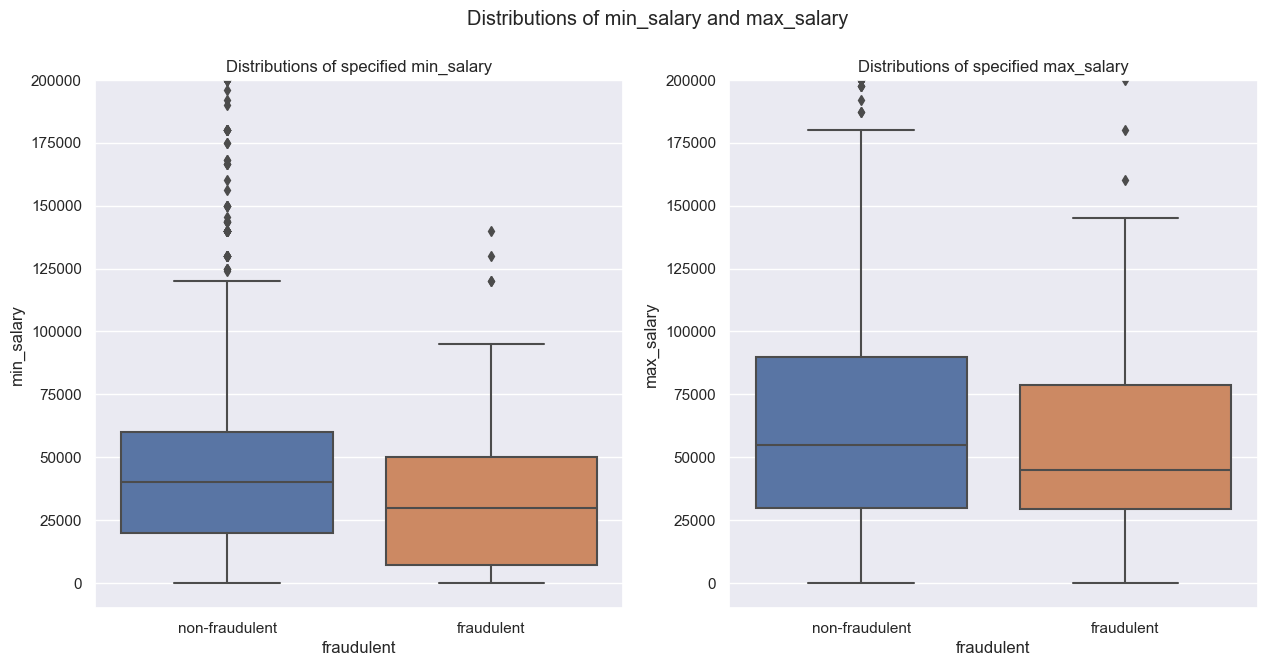

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for ind, feature_name in enumerate(num_features):
    sns.boxplot(y=feature_name, x='fraudulent', data=data[data.salary_specified == 1], ax=axes[ind])
    axes[ind].set_ylim([-1e4, 2e5])
    axes[ind].set_xticklabels(['non-fraudulent', 'fraudulent'])
    axes[ind].set_title(f'Distributions of specified {feature_name}')

fig.suptitle('Distributions of min_salary and max_salary')
fig.show()

Those who write fake job posts often offer slightly lower salaries... Let's look at pairwise average salaries:

In [136]:
diff_salary = data[data.salary_specified == 1]['max_salary'] - data[data.salary_specified == 1]['min_salary']

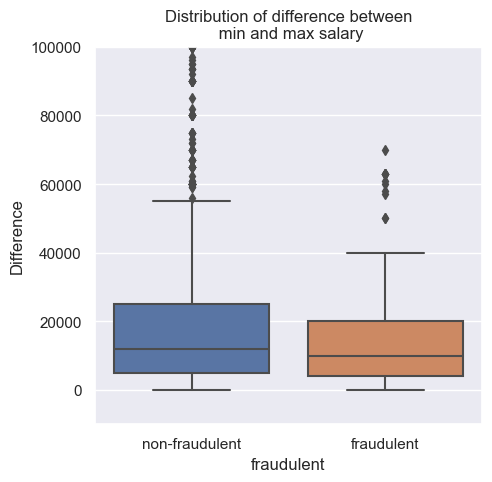

In [137]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=diff_salary, x='fraudulent', data=data[data.salary_specified == 1])
plt.ylim([-1e4, 1e5])
plt.xticks([0, 1], ['non-fraudulent', 'fraudulent'])
plt.ylabel('Difference')
plt.title('Distribution of difference between\n min and max salary')
plt.show()

---

In [138]:
specified_salaries = data[data.salary_specified == 1][num_features]
specified_salaries['difference'] = diff_salary
specified_salaries['fraudulent'] = data.fraudulent
specified_salaries.head()

,min_salary,max_salary,difference,fraudulent
6,20000,28000,8000,0
10,100000,120000,20000,0
15,120000,150000,30000,0
23,100000,120000,20000,0
31,50000,65000,15000,0


In [139]:
np.sum(np.unique(specified_salaries.min_salary, return_counts=True)[1] > 10)

48

In [140]:
np.sum(np.unique(specified_salaries.max_salary, return_counts=True)[1] > 10)

47

In [149]:
def print_stats_for_salary(feature_name):
    '''Calculates statistics for fraudulent and non-fraudulent salary-feature.'''
    np.random.seed(42)
    feature_0f = specified_salaries[specified_salaries.fraudulent == 0][feature_name]
    feature_1f = specified_salaries[specified_salaries.fraudulent == 1][feature_name]
    
    med_0f = np.median(feature_0f)
    med_1f = np.median(feature_1f)
    med_0f_confint = stats.bootstrap_confint(feature_0f.values, stat=np.median)
    med_1f_confint = stats.bootstrap_confint(feature_1f.values, stat=np.median)
    
    bigger_med, smaller_med = (feature_0f, feature_1f) if med_0f > med_1f else (feature_1f, feature_0f)
    med_diff = np.median(bigger_med) - np.median(smaller_med)
    med_diff_confint = stats.bootstrap_confint_diff(bigger_med.values, smaller_med.values, stat=np.median)
    perm_test_p = stats.permutation_test_ind(feature_0f, feature_1f, max_permutations=5000)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Median of {feature_name} in non-fraudulent posts: {med_0f}')
    print(f'Median of {feature_name} in fraudulent posts:     {med_1f}')
    print(f'Confidence interval for the median of {feature_name} in non-fraudulent posts: {med_0f_confint}')
    print(f'Confidence interval for the median of {feature_name} in fraudulent posts:     {med_1f_confint}')
    print(f'Difference in these medians: {med_diff}')
    print(f'Confidence interval for the difference in these medians: {med_diff_confint}')
    print(f'Permutation test result: {perm_test_p} (p-value)')

In [150]:
print_stats_for_salary('min_salary')

Feature: min_salary
Median of min_salary in non-fraudulent posts: 40000.0
Median of min_salary in fraudulent posts:     30000.0
Confidence interval for the median of min_salary in non-fraudulent posts: [39000. 40000.]
Confidence interval for the median of min_salary in fraudulent posts:     [27000. 30000.]
Difference in these medians: 10000.0
Confidence interval for the difference in these medians: [ 9000. 13000.]
Permutation test result: 0.8066 (p-value)


In [151]:
print_stats_for_salary('max_salary')

Feature: max_salary
Median of max_salary in non-fraudulent posts: 55000.0
Median of max_salary in fraudulent posts:     45000.0
Confidence interval for the median of max_salary in non-fraudulent posts: [50000. 58000.]
Confidence interval for the median of max_salary in fraudulent posts:     [40000. 50000.]
Difference in these medians: 10000.0
Confidence interval for the difference in these medians: [    0. 15000.]
Permutation test result: 0.8924 (p-value)


In [152]:
print_stats_for_salary('difference')

Feature: difference
Median of difference in non-fraudulent posts: 12000.0
Median of difference in fraudulent posts:     10000.0
Confidence interval for the median of difference in non-fraudulent posts: [10000. 15000.]
Confidence interval for the median of difference in fraudulent posts:     [ 8000. 10000.]
Difference in these medians: 2000.0
Confidence interval for the difference in these medians: [   0. 5000.]
Permutation test result: 0.853 (p-value)


---

There is a difference in medians, let's calculate them and some descriptive statistics (there is no sense in compairing means because there are too many outliers here):

Differencies between `min_salary`'s medians of 0 and 1 `fraudulent` groups are much more significant than between `max_salary`'s ones. OK. 

Let's compare mean count of words in text of each textual feature for groups of 0 and 1 `fraudulent`:

---

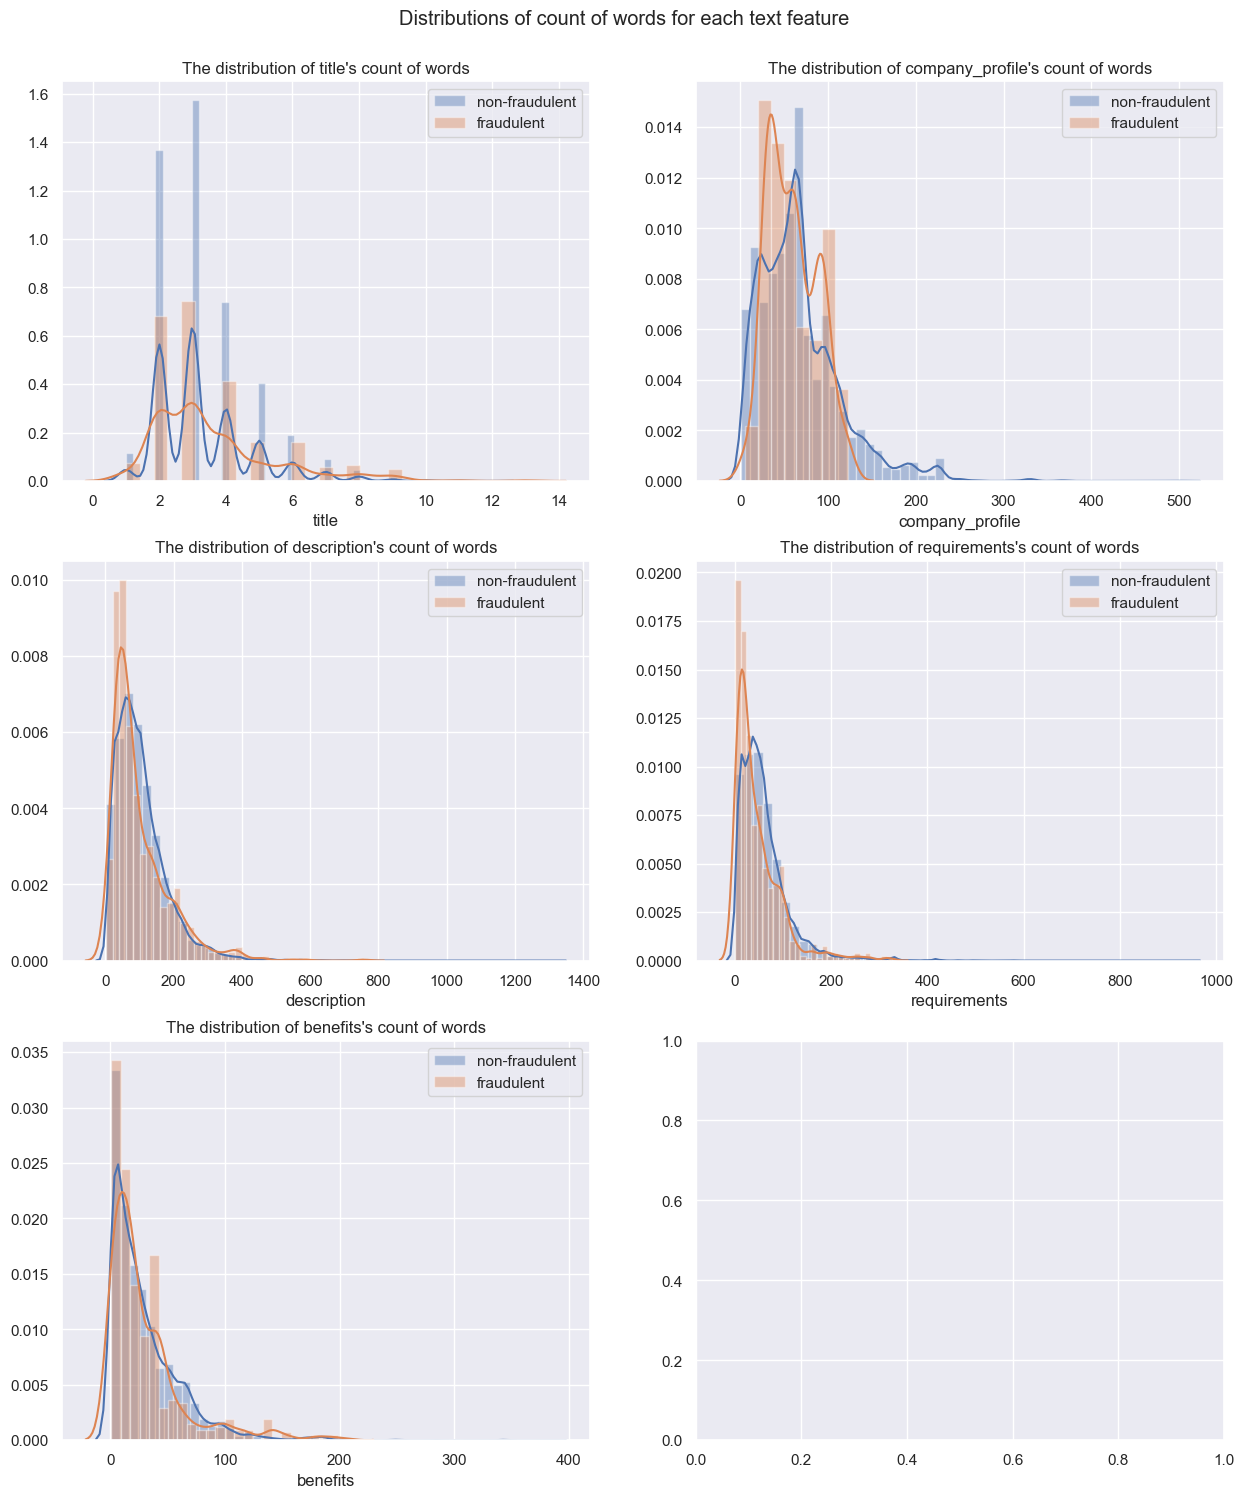

In [153]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

text_features_gen = iter(text_features)

for row in range(3):
    for col in range(2):
        try:
            feature_name = next(text_features_gen)
        except StopIteration:
            break
        
        if feature_name == 'title':
            feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
        else:
            feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)

        fv_0f_len = feature_values_0f.str.split(' ').apply(len)
        fv_1f_len = feature_values_1f.str.split(' ').apply(len)
        
        sns.distplot(fv_0f_len, label='non-fraudulent', ax=axes[row, col])
        sns.distplot(fv_1f_len, label='fraudulent', ax=axes[row, col])
        axes[row, col].set_title(f'The distribution of {feature_name}\'s count of words')
        axes[row, col].legend()
        
fig.suptitle('Distributions of count of words for each text feature', y=0.92)
fig.show()

In [154]:
def print_stats_for_texts(feature_name):
    '''Calculates statistics for fraudulent and non-fraudulent count of words in feature\'s texts.'''
    if feature_name == 'title':
        feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
    else:
        feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)
    
    lens_0f = feature_values_0f.str.split(' ').apply(len)
    lens_1f = feature_values_1f.str.split(' ').apply(len)
    
    mean_lens_0f = round(np.mean(lens_0f), 4)
    mean_lens_1f = round(np.mean(lens_1f), 4)
    mean_lens_0f_confint = round_confint(stats.tconfint(lens_0f.values))
    mean_lens_1f_confint = round_confint(stats.tconfint(lens_1f.values))
    
    bigger_mean, smaller_mean = (lens_0f, lens_1f) if mean_lens_0f > mean_lens_1f else (lens_1f, lens_0f)
    mean_diff = round(np.mean(bigger_mean) - np.mean(smaller_mean), 4)
    
    mean_diff_confint = round_confint(stats.tconfint_diff(bigger_mean.values, smaller_mean.values))
    perm_test_p = stats.permutation_test_ind(lens_0f, lens_1f, max_permutations=5000)[1]
    
    print(f'Feature: {feature_name}\n======')
    print(f'Mean of {feature_name}\'s count of words in non-fraudulent posts: {mean_lens_0f}')
    print(f'Mean of {feature_name}\'s count of words in fraudulent posts:     {mean_lens_1f}')
    print(f'Confidence interval for the mean of {feature_name}\'s count of words in non-fraudulent posts: {mean_lens_0f_confint}')
    print(f'Confidence interval for the mean of {feature_name}\'s count of words in fraudulent posts:     {mean_lens_1f_confint}')
    print(f'Difference in these means: {mean_diff}')
    print(f'Confidence interval for the difference in these means: {mean_diff_confint}')
    print(f'Permutation test result: {perm_test_p} (p-value)')

In [155]:
for feature_name in text_features:
    print_stats_for_texts(feature_name)
    print()

Feature: title
Mean of title's count of words in non-fraudulent posts: 3.2794
Mean of title's count of words in fraudulent posts:     3.5612
Confidence interval for the mean of title's count of words in non-fraudulent posts: [3.258, 3.3007]
Confidence interval for the mean of title's count of words in fraudulent posts:     [3.4392, 3.6832]
Difference in these means: 0.2818
Confidence interval for the difference in these means: [0.158, 0.4057]
Permutation test result: 0.0002 (p-value)

Feature: company_profile
Mean of company_profile's count of words in non-fraudulent posts: 66.9309
Mean of company_profile's count of words in fraudulent posts:     59.2294
Confidence interval for the mean of company_profile's count of words in non-fraudulent posts: [66.1698, 67.692]
Confidence interval for the mean of company_profile's count of words in fraudulent posts:     [55.9672, 62.4916]
Difference in these means: 7.7015
Confidence interval for the difference in these means: [4.3524, 11.0505]
Permu

In [156]:
data['company_profile_count_of_words'] = data['company_profile'].astype(str).str.split(' ').apply(len)
data['requirements_count_of_words'] = data['requirements'].astype(str).str.split(' ').apply(len)
data.head()[['company_profile_count_of_words', 'requirements_count_of_words']]

,company_profile_count_of_words,requirements_count_of_words
0,86,73
1,96,117
2,75,103
3,55,121
4,146,61


In [157]:
num_features += ['company_profile_count_of_words', 'requirements_count_of_words']

---

Differencies in `title`, `description` and `benefits` are not too significant. But it may be usefull to add two numerical features to dataset that will describe counts of words in `company_profile` and `requirements`:

We can build a "chain" and transform it into a sentense using bigrams with the 43 `count_1f` value from the `bigram_1f` column if we start reading them in order. It seems that many of fraudulent company profiles were written using the same pattern. But if we pay attention to `count_0f` bigrams in indexes \[8, ..., 15\] we see a similar situation. Isn't it strange?..

Enough, however. Time to fit models.

## Transforming features and fitting models

Firstly let's increase the count of 1 `fraudulent` records in the dataset using oversampling:

In [170]:
data_1f = data[data.fraudulent == 1]

In [171]:
data = pd.concat([data] + [data_1f] * 7, axis=0)

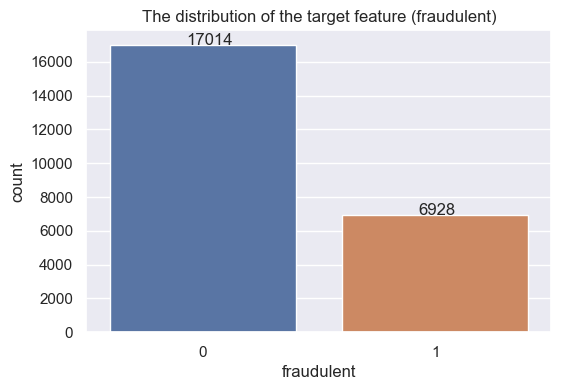

In [172]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('The distribution of the target feature (fraudulent)')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))

plt.show()

Cross-validation splitter:

In [173]:
skf = StratifiedKFold(n_splits=4, random_state=42)

Our features and targets:

In [174]:
X, y = data.drop('fraudulent', axis=1), data.fraudulent

Numerical features have to be scaled, categorical features have to be transformed into sets of binary ones and text features have to be vectorized (I'm using TF-IDF method):

In [175]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        *[(feature_name, text_transformer, feature_name) 
          for feature_name in text_features]
    ]
)

We'll start with a logistic regression model (default parameters):

In [176]:
log_reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression())])

In [177]:
%%time
cv_scores = cross_validate(log_reg_pipe, X, y, return_train_score=True, cv=skf, 
                           scoring=['accuracy', 'roc_auc'], n_jobs=-1)

print(f'Accuracy on train part: {cv_scores["train_accuracy"]}, mean: {cv_scores["train_accuracy"].mean()}')
print(f'Accuracy on test part:  {cv_scores["test_accuracy"]}, mean: {cv_scores["test_accuracy"].mean()}')
print(f'ROC AUC on train part: {cv_scores["train_roc_auc"]}, mean: {cv_scores["train_roc_auc"].mean()}')
print(f'ROC AUC on test part:  {cv_scores["test_roc_auc"]}, mean: {cv_scores["test_roc_auc"].mean()}')

Accuracy on train part: [0.99955447 0.99944308 0.99938743 0.99955449], mean: 0.9994848665917131
Accuracy on test part:  [0.99047778 0.98880722 0.99548872 0.99298246], mean: 0.9919390440685744
ROC AUC on train part: [0.99996796 0.9999914  0.99996751 0.99996932], mean: 0.9999740513869914
ROC AUC on test part:  [0.99919679 0.998516   0.99986262 0.99934512], mean: 0.9992301304991087
CPU times: user 654 ms, sys: 561 ms, total: 1.22 s
Wall time: 3min 19s


I think we can stop at this point. Maybe the dataset wasn't assembled correctly or there are too few records in it... Or maybe I've done something wrong, but the data is too easy to classify. Or maybe everything is alright? Let's check model's weights:

In [178]:
%%time
feature_names = num_features.copy()

num_features_scaled = StandardScaler().fit_transform(data[num_features])
X = num_features_scaled

feature_names += bin_features
X = np.hstack([X, data[bin_features]])


for feature_name in cat_features:
    encoder = OneHotEncoder()
    encoded_feature = encoder.fit_transform(data[feature_name].values.reshape(-1, 1))
    
    X = sparse_hstack([X, encoded_feature])
    f_names = list(map(lambda cat: f'{feature_name}:{cat}', encoder.categories_[0]))
    feature_names += f_names

for feature_name in text_features:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    vectorized_feature = vectorizer.fit_transform(data[feature_name])
    
    X = sparse_hstack([X, vectorized_feature])
    sorted_phrases = [pair[0] for pair in list(sorted(vectorizer.vocabulary_.items(), 
                                                      key=lambda pair: pair[1]))]
    f_names = list(map(lambda phrase: f'{feature_name}:{phrase}', sorted_phrases))
    feature_names += f_names

CPU times: user 21.4 s, sys: 859 ms, total: 22.3 s
Wall time: 23.3 s


In [179]:
X.shape[1], len(feature_names)

(1273072, 1273072)

In [180]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1).fit(X, y)

Weights x feature names:

In [181]:
eli5.explain_weights(log_reg, feature_names=feature_names, top=(30, 30))

Weight?,Feature
+2.556,department:Information Technology
+2.547,industry:Oil & Energy
+2.368,country:MY
+2.275,benefits:salaryk
+2.268,title:administr
+2.246,title:custom assist
+2.241,city:AUSTIN
+2.222,city:San Mateo
+2.166,title:posit
+2.108,industry:Accounting


I think everything is pretty good though... At least `country` feature is usefull (I considered the option of leaving the `location` feature as a categorical one):

In [182]:
data[data.country == 'MY'].fraudulent.value_counts()

1    96
0     9
Name: fraudulent, dtype: int64

In [183]:
data[data.country == 'GR'].fraudulent.value_counts()

0    940
Name: fraudulent, dtype: int64

Using the info about weights we can figure out which values of a feature are associated with the biggest and the smallest proportions of fraudulent posts:

In [184]:
data[data.industry == 'Accounting'].fraudulent.value_counts()

1    456
0    102
Name: fraudulent, dtype: int64

In [185]:
data[data.industry == 'Internet'].fraudulent.value_counts()

0    1062
Name: fraudulent, dtype: int64

And we can also conclude that fraudulent post writers often start writing `London` (and many other city names) using the lowercase letter:

In [186]:
data[data.city == 'london'].fraudulent.value_counts()

1    24
0    11
Name: fraudulent, dtype: int64

In [187]:
data[data.city == 'London'].fraudulent.value_counts()

0    1056
1      32
Name: fraudulent, dtype: int64